***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [17]:
df=pd.read_csv('Javascript.csv')

df.rename(columns={'Malicious':'Target'},inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
df.drop(['js_function_Object.defineProperty(','js_function_Object.keys(','js_function_.substr','js_function_unescape('],axis=1,inplace=True)

print("Shape of our dataset:",df.shape)


Shape of our dataset: (43294, 397)


#### Let us analyze the balance of classes

In [18]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [19]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))

### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

113 columns have only one unique value in them rendering them meaningless for classification
Shape of our dataset after dropping them: (43294, 284)


In [20]:
### Check and converting data types
df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

#### Check for missing data

#### No missing data exists

#### Next check to see which features have less than 5% varying data

In [21]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

234 columns have more than 95% same values


In [22]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [23]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())
columns=columns.tolist()+['Target']

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substring(',
 'js_function_.test(',
 'js_function_.toLowe

#### lets see if for the rest of continuous variables if there exists any relationship using Point biserial correlation.
####  The PointBiserial Correlation is a special case of Pearson co-rrelation for Correlation between continuous and dichotomus binary variable. 

In [24]:
df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for JavaScript experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for JavaScript experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for JavaScript experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
dom_function_document.getElementsByTagName(,-0.206833,0.000000e+00,-94.422955,0.000000e+00
dom_function_document.createElement(,-0.154604,9.233651e-230,-72.422095,0.000000e+00
js_function_.getTime(,-0.149504,8.006211e-215,-70.045384,0.000000e+00
dom_function_window.addEventListener(,-0.107093,1.299881e-110,-51.397683,0.000000e+00
js_function_.split(,-0.097541,5.300145e-92,-46.252895,0.000000e+00
js_function_Math.random(,-0.094978,2.620317e-87,-44.513654,0.000000e+00
js_function_.setTime(,-0.083818,2.410642e-68,-41.813198,0.000000e+00
js_function_.replace(,-0.087844,6.536777e-75,-38.924200,0.000000e+00
js_function_.indexOf(,-0.075600,6.618535e-56,-36.469099,9.453374e-287



Stats for Categorical features for JavaScript experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


#### The ttest conduncted supports the results of point biserial correlation. 

#### Hence, we see that all the features we selected are related to the dependent variable.

### Lets start by building some basic models 

In [25]:
columns.remove('Target')

In [26]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [27]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [28]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [29]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.839093402627
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24346  5279    29625
True         294  4716     5010
__all__    24640  9995    34635

Accuracy of the KNN model for twst data is: 0.836817184432
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6067  1316     7383
True          97  1179     1276
__all__     6164  2495     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855233145662
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29605    20    29625
True        4994    16     5010
__all__    34599    36    34635

Accuracy of the Logistic Regression model for twst data is: 0.851830465412
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7373    10     7383
True        1273     3     1276
__all__     8646    13     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.864327991916
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29572    53    29625
True        4646   364     5010
__all__    34218   417    34635

Accuracy of the Random Forest Classifier for twst data is: 0.856449936482
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7357    26     7383
True        1217    59     1276
__all__     8574    85     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.852345892883
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29493   132    29625
True        4982    28     5010
__all__    34475   160    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.848596835662
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7343    40     7383
True        1271     5     1276
__all__     8614    45     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.857456330302
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29601    24    29625
True        4913    97     5010
__all__    34514   121    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.853793740617
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7374     9     7383
True        1257    19     1276
__all__     8631    28     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.865136422694
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29579    46    29625
True        4625   385     5010
__all__    34204   431    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.856680910036
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7359    24     7383
True        1217    59     1276
__all__     8576    83     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.864443482027
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29576    49    29625
True        4646   364     5010
__all__    34222   413    34635

Accuracy of the Bagging model for twst data is: 0.856103476152
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7352    31     7383
True        1215    61     1276
__all__     8567    92     8659



Neural Network-1
The accuracy of the model on training data is: 0.862624512774


Predicted  False  True  __all__
Actual                         
False      29580    45    29625
True        4713   297     5010
__all__    34293   342    34635

The accuracy of the model on test data is: 0.855410555491


Predicted  False  True  __all__
Actual                         
False       7359    24     7383
True        1228    48     1276
__all__     8587    72     8659

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [30]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [31]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.839093,4716.0,24346.0,5279.0,294.0,0.178194,0.058683
LogisticRegression,0.855233,16.0,29605.0,20.0,4994.0,0.000675,0.996806
RandomForestClassifier,0.864328,364.0,29572.0,53.0,4646.0,0.001789,0.927345
AdaBoostClassifier,0.852346,28.0,29493.0,132.0,4982.0,0.004456,0.994411
GradientBoostingClassifier,0.857456,97.0,29601.0,24.0,4913.0,0.000810,0.980639
ExtraTreeClassifier,0.865136,385.0,29579.0,46.0,4625.0,0.001553,0.923154
BaggingClassifier,0.864443,364.0,29576.0,49.0,4646.0,0.001654,0.927345
Neural Network-1,0.862625,297.0,29580.0,45.0,4713.0,0.001519,0.940719


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.836817,1179.0,6067.0,1316.0,97.0,0.178247,0.076019,0.872867
LogisticRegression,0.851830,3.0,7373.0,10.0,1273.0,0.001354,0.997649,0.500498
RandomForestClassifier,0.856450,59.0,7357.0,26.0,1217.0,0.003522,0.953762,0.521358
AdaBoostClassifier,0.848597,5.0,7343.0,40.0,1271.0,0.005418,0.996082,0.499250
GradientBoostingClassifier,0.853794,19.0,7374.0,9.0,1257.0,0.001219,0.985110,0.506836
ExtraTreeClassifier,0.856681,59.0,7359.0,24.0,1217.0,0.003251,0.953762,0.521494
BaggingClassifier,0.856103,61.0,7352.0,31.0,1215.0,0.004199,0.952194,0.521803
Neural Network-1,0.855411,48.0,7359.0,24.0,1228.0,0.003251,0.962382,0.521803


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [32]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [33]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [34]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 43294, Columns: 50]
  Relationships:
    No relationships

In [35]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 4753 features
EntitySet scattered to workers in 5.560 seconds
Elapsed: 00:34 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [36]:
feature_matrix_sessions.head()

,dom_function_document.createElement(,dom_function_document.getElementById(,dom_function_document.getElementsByTagName(,dom_function_document.querySelector(,dom_function_document.write(,dom_function_window.addEventListener(,dom_function_window.open(,dom_function_window.setTimeout(,js_function_.add(,js_function_.apply(,js_function_.bind(,js_function_.call(,js_function_.charAt(,js_function_.concat(,js_function_.defineProperty(,js_function_.exec(,js_function_.find(,js_function_.forEach(,js_function_.get(,js_function_.getTime(,js_function_.hasOwnProperty(,js_function_.indexOf(,js_function_.join(,js_function_.keys(,js_function_.log(,js_function_.match(,js_function_.pop(,js_function_.push(,js_function_.replace(,js_function_.setTime(,js_function_.shift(,js_function_.slice(,js_function_.split(,js_function_.substring(,js_function_.test(,js_function_.toLowerCase(,js_function_.toString(,js_function_.trim(,js_function_JSON.parse(,js_function_JSON.stringify(,js_function_Math.floor(,js_function_Math.max(,js_function_Math.random(,js_function_Math.round(,js_function_decodeURIComponent(,js_function_encodeURIComponent(,js_function_escape(,js_function_isNaN(,js_function_parseInt(,dom_function_window.addEventListener( + js_function_Math.floor(,dom_function_document.getElementById( + js_function_.forEach(,js_function_isNaN( + js_function_parseInt(,js_function_.match( + js_function_JSON.stringify(,dom_function_window.addEventListener( + dom_function_window.setTimeout(,dom_function_document.createElement( + dom_function_document.getElementById(,js_function_.setTime( + js_function_.toLowerCase(,js_function_JSON.stringify( + js_function_Math.random(,js_function_.hasOwnProperty( + js_function_.slice(,js_function_.join( + js_function_.keys(,js_function_.replace( + js_function_isNaN(,dom_function_document.getElementById( + js_function_isNaN(,dom_function_document.createElement( + js_function_.replace(,js_function_.exec( + js_function_Math.max(,js_function_.log( + js_function_.toLowerCase(,js_function_.split( + js_function_encodeURIComponent(,js_function_.setTime( + js_function_decodeURIComponent(,js_function_.hasOwnProperty( + js_function_.indexOf(,js_function_.charAt( + js_function_.defineProperty(,js_function_.hasOwnProperty( + js_function_Math.max(,js_function_.add( + js_function_decodeURIComponent(,dom_function_document.write( + js_function_Math.floor(,js_function_.push( + js_function_.toLowerCase(,js_function_.call( + js_function_encodeURIComponent(,js_function_.pop( + js_function_.split(,js_function_.getTime( + js_function_parseInt(,js_function_.substring( + js_function_escape(,js_function_.slice( + js_function_.test(,dom_function_document.createElement( + js_function_.find(,js_function_.getTime( + js_function_encodeURIComponent(,dom_function_document.write( + js_function_.call(,js_function_.defineProperty( + js_function_.log(,js_function_.defineProperty( + js_function_Math.max(,js_function_.find( + js_function_.join(,js_function_.add( + js_function_.indexOf(,js_function_.get( + js_function_.join(,js_function_.substring( + js_function_Math.max(,js_function_.toLowerCase( + js_function_JSON.stringify(,js_function_.add( + js_function_.exec(,dom_function_document.querySelector( + js_function_.substring(,js_function_.indexOf( + js_function_Math.floor(,dom_function_document.getElementsByTagName( + js_function_.find(,js_function_.add( + js_function_.slice(,js_function_.get( + js_function_.hasOwnProperty(,dom_function_window.open( + js_function_.concat(,js_function_escape( + js_function_Math.floor(,js_function_.bind( + js_function_JSON.parse(,dom_function_document.getElementsByTagName( + js_function_.getTime(,js_function_.defineProperty( + js_function_.toLowerCase(,dom_function_document.write( + js_function_.shift(,js_function_.get( + js_function_.match(,js_function_.pop( + js_function_.test(,js_function_.call( + js_function_.defineProperty(,js_function_.forEach( + js_function_.match(,dom_function_document.querySelector( + dom_function_window.setTimeout(,j

In [37]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [38]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [39]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [40]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [41]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [42]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [43]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [44]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(43294, 46)

In [45]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['js_function_.getTime( / js_function_.push(',
 'js_function_.getTime( + js_function_Math.random(',
 'js_function_.getTime( + js_function_.split(',
 'js_function_.getTime( + js_function_.setTime(',
 'js_function_.getTime( + js_function_.pop(',
 'dom_function_window.addEventListener( + js_function_.getTime(',
 'dom_function_document.getElementsByTagName( / js_function_.push(',
 'dom_function_document.getElementsByTagName( / dom_function_document.createElement(',
 'dom_function_document.getElementsByTagName( + js_function_Math.round(',
 'dom_function_document.getElementsByTagName( + js_function_Math.random(',
 'dom_function_document.getElementsByTagName( + js_function_Math.floor(',
 'dom_function_document.getElementsByTagName( + js_function_JSON.parse(',
 'dom_function_document.getElementsByTagName( + js_function_.split(',
 'dom_function_document.getElementsByTagName( + js_function_.shift(',
 'dom_function_document.getElementsByTagName( + js_function_.setTime(',
 'dom_function_document.g

In [46]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [47]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.858582358886
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29535    91    29626
True        4807   202     5009
__all__    34342   293    34635

Accuracy of the KNN model for twst data is: 0.853447280286
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7352    30     7382
True        1239    38     1277
__all__     8591    68     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855117655551
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29616    10    29626
True        5008     1     5009
__all__    34624    11    34635

Accuracy of the Logistic Regression model for twst data is: 0.851945952188
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7377     5     7382
True        1277     0     1277
__all__     8654     5     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.860459073192
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29546    80    29626
True        4753   256     5009
__all__    34299   336    34635

Accuracy of the Random Forest Classifier for twst data is: 0.853447280286
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7352    30     7382
True        1239    38     1277
__all__     8591    68     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.855204273134
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29619     7    29626
True        5008     1     5009
__all__    34627     8    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.852176925742
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7379     3     7382
True        1277     0     1277
__all__     8656     3     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.856330301718
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29623     3    29626
True        4973    36     5009
__all__    34596    39    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.852754359626
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7380     2     7382
True        1273     4     1277
__all__     8653     6     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.860978778692
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29557    69    29626
True        4746   263     5009
__all__    34303   332    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.854486661277
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7360    22     7382
True        1238    39     1277
__all__     8598    61     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.860459073192
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29548    78    29626
True        4755   254     5009
__all__    34303   332    34635

Accuracy of the Bagging model for twst data is: 0.85333179351
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7351    31     7382
True        1239    38     1277
__all__     8590    69     8659



Neural Network-1
The accuracy of the model on training data is: 0.859448534719


Predicted  False  True  __all__
Actual                         
False      29550    76    29626
True        4792   217     5009
__all__    34342   293    34635

The accuracy of the model on test data is: 0.85402471417


Predicted  False  True  __all__
Actual                         
False       7355    27     7382
True        1237    40     1277
__all__     8592    67     8659

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [48]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [49]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.858582,202.0,29535.0,91.0,4807.0,0.003072,0.959673
LogisticRegression,0.855118,1.0,29616.0,10.0,5008.0,0.000338,0.999800
RandomForestClassifier,0.860459,256.0,29546.0,80.0,4753.0,0.002700,0.948892
AdaBoostClassifier,0.855204,1.0,29619.0,7.0,5008.0,0.000236,0.999800
GradientBoostingClassifier,0.856330,36.0,29623.0,3.0,4973.0,0.000101,0.992813
ExtraTreeClassifier,0.860979,263.0,29557.0,69.0,4746.0,0.002329,0.947495
BaggingClassifier,0.860459,254.0,29548.0,78.0,4755.0,0.002633,0.949291
Neural Network-1,0.859449,217.0,29550.0,76.0,4792.0,0.002565,0.956678


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.853447,38.0,7352.0,30.0,1239.0,0.004064,0.970243,0.512847
LogisticRegression,0.851946,0.0,7377.0,5.0,1277.0,0.000677,1.000000,0.499661
RandomForestClassifier,0.853447,38.0,7352.0,30.0,1239.0,0.004064,0.970243,0.512847
AdaBoostClassifier,0.852177,0.0,7379.0,3.0,1277.0,0.000406,1.000000,0.499797
GradientBoostingClassifier,0.852754,4.0,7380.0,2.0,1273.0,0.000271,0.996868,0.501431
ExtraTreeClassifier,0.854487,39.0,7360.0,22.0,1238.0,0.002980,0.969460,0.513780
BaggingClassifier,0.853332,38.0,7351.0,31.0,1239.0,0.004199,0.970243,0.512779
Neural Network-1,0.854025,40.0,7355.0,27.0,1237.0,0.003658,0.968677,0.512779


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [50]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [51]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

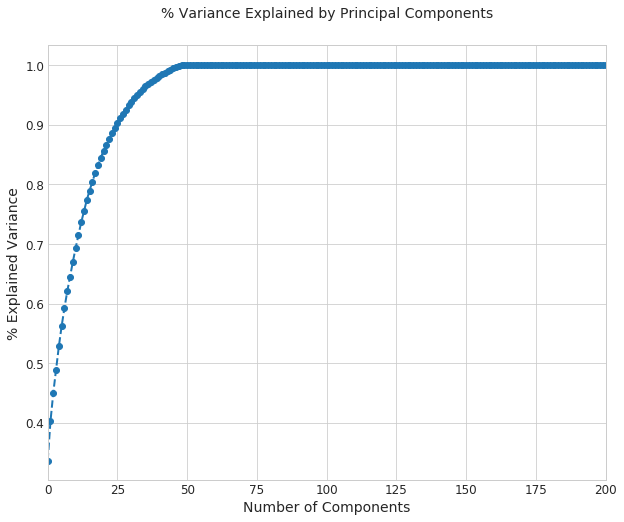

In [52]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [53]:
pca=PCA(n_components=50,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 50 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 50 components is: 1.0


In [54]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [55]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [56]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,50).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.841865165295
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24484  5142    29626
True         335  4674     5009
__all__    24819  9816    34635

Accuracy of the KNN model for twst data is: 0.835431343111
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6064  1318     7382
True         107  1170     1277
__all__     6171  2488     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855637361051
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29617     9    29626
True        4991    18     5009
__all__    34608    27    34635

Accuracy of the Logistic Regression model for twst data is: 0.852061438965
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7376     6     7382
True        1275     2     1277
__all__     8651     8     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.865511765555
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29575    51    29626
True        4607   402     5009
__all__    34182   453    34635

Accuracy of the Random Forest Classifier for twst data is: 0.857027370366
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7360    22     7382
True        1216    61     1277
__all__     8576    83     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.857340840191
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29599    27    29626
True        4914    95     5009
__all__    34513   122    34635

Accuracy of the Ada Boost Classifier for twst data is: 0.853447280286
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7376     6     7382
True        1263    14     1277
__all__     8639    20     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.862480150137
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29591    35    29626
True        4728   281     5009
__all__    34319   316    34635

Accuracy of the Gradient Boosting Classifier for twst data is: 0.855526042268
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7360    22     7382
True        1229    48     1277
__all__     8589    70     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.866291323805
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29578    48    29626
True        4583   426     5009
__all__    34161   474    34635

Accuracy of the Extra Tree Classifier for twst data is: 0.856680910036
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7356    26     7382
True        1215    62     1277
__all__     8571    88     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.865309657861
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29566    60    29626
True        4605   404     5009
__all__    34171   464    34635

Accuracy of the Bagging model for twst data is: 0.856218962929
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7353    29     7382
True        1216    61     1277
__all__     8569    90     8659



Neural Network-1
The accuracy of the model on training data is: 0.863952649054


Predicted  False  True  __all__
Actual                         
False      29579    47    29626
True        4665   344     5009
__all__    34244   391    34635

The accuracy of the model on test data is: 0.855295068715


Predicted  False  True  __all__
Actual                         
False       7354    28     7382
True        1225    52     1277
__all__     8579    80     8659

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [57]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [58]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.841865,4674.0,24484.0,5142.0,335.0,0.173564,0.066880
LogisticRegression,0.855637,18.0,29617.0,9.0,4991.0,0.000304,0.996406
RandomForestClassifier,0.865512,402.0,29575.0,51.0,4607.0,0.001721,0.919744
AdaBoostClassifier,0.857341,95.0,29599.0,27.0,4914.0,0.000911,0.981034
GradientBoostingClassifier,0.862480,281.0,29591.0,35.0,4728.0,0.001181,0.943901
ExtraTreeClassifier,0.866291,426.0,29578.0,48.0,4583.0,0.001620,0.914953
BaggingClassifier,0.865310,404.0,29566.0,60.0,4605.0,0.002025,0.919345
Neural Network-1,0.863953,344.0,29579.0,47.0,4665.0,0.001586,0.931324


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.835431,1170.0,6064.0,1318.0,107.0,0.178542,0.083790,0.868834
LogisticRegression,0.852061,2.0,7376.0,6.0,1275.0,0.000813,0.998434,0.500377
RandomForestClassifier,0.857027,61.0,7360.0,22.0,1216.0,0.002980,0.952232,0.522394
AdaBoostClassifier,0.853447,14.0,7376.0,6.0,1263.0,0.000813,0.989037,0.505075
GradientBoostingClassifier,0.855526,48.0,7360.0,22.0,1229.0,0.002980,0.962412,0.517304
ExtraTreeClassifier,0.856681,62.0,7356.0,26.0,1215.0,0.003522,0.951449,0.522515
BaggingClassifier,0.856219,61.0,7353.0,29.0,1216.0,0.003928,0.952232,0.521920
Neural Network-1,0.855295,52.0,7354.0,28.0,1225.0,0.003793,0.959280,0.521920


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [59]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,50).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [60]:
columns=col_values[col_values['95_%_same_values']==False].index.values
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substring(',
 'js_function_.test(',
 'js_function_.toLowe

In [61]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [63]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [64]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.886767932489
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24250   5375    29625
True        1334  28291    29625
__all__    25584  33666    59250

Accuracy of the KNN model for twst data is: 0.831966739808
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6038  1345     7383
True         110  1166     1276
__all__     6148  2511     8659



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.814548523207
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      19990   9635    29625
True        1353  28272    29625
__all__    21343  37907    59250

Accuracy of the Logistic Regression model for twst data is: 0.711398544867
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       4956  2427     7383
True          72  1204     1276
__all__     5028  3631     8659



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.904776371308
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24210   5415    29625
True         227  29398    29625
__all__    24437  34813    59250

Accuracy of the Random Forest Classifier for twst data is: 0.83439196212
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6013  1370     7383
True          64  1212     1276
__all__     6077  2582     8659



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.854801687764
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22537   7088    29625
True        1515  28110    29625
__all__    24052  35198    59250

Accuracy of the Ada Boost Classifier for twst data is: 0.784155214228
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5598  1785     7383
True          84  1192     1276
__all__     5682  2977     8659



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.882767932489
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23742   5883    29625
True        1063  28562    29625
__all__    24805  34445    59250

Accuracy of the Gradient Boosting Classifier for twst data is: 0.823074257997
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5924  1459     7383
True          73  1203     1276
__all__     5997  2662     8659



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.905215189873
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24218   5407    29625
True         209  29416    29625
__all__    24427  34823    59250

Accuracy of the Extra Tree Classifier for twst data is: 0.834853909227
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6015  1368     7383
True          62  1214     1276
__all__     6077  2582     8659



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.904540084388
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24211   5414    29625
True         242  29383    29625
__all__    24453  34797    59250

Accuracy of the Bagging model for twst data is: 0.832544173692
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5994  1389     7383
True          61  1215     1276
__all__     6055  2604     8659



Neural Network-1
The accuracy of the model on training data is: 0.89746835443


Predicted  False   True  __all__
Actual                          
False      24084   5541    29625
True         534  29091    29625
__all__    24618  34632    59250

The accuracy of the model on test data is: 0.829079570389


Predicted  False  True  __all__
Actual                         
False       5965  1418     7383
True          62  1214     1276
__all__     6027  2632     8659

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [65]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [66]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.886768,28291.0,24250.0,5375.0,1334.0,0.181435,0.045030
LogisticRegression,0.814549,28272.0,19990.0,9635.0,1353.0,0.325232,0.045671
RandomForestClassifier,0.904776,29398.0,24210.0,5415.0,227.0,0.182785,0.007662
AdaBoostClassifier,0.854802,28110.0,22537.0,7088.0,1515.0,0.239257,0.051139
GradientBoostingClassifier,0.882768,28562.0,23742.0,5883.0,1063.0,0.198582,0.035882
ExtraTreeClassifier,0.905215,29416.0,24218.0,5407.0,209.0,0.182515,0.007055
BaggingClassifier,0.904540,29383.0,24211.0,5414.0,242.0,0.182751,0.008169
Neural Network-1,0.897468,29091.0,24084.0,5541.0,534.0,0.187038,0.018025


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.831967,1166.0,6038.0,1345.0,110.0,0.182175,0.086207,0.865809
LogisticRegression,0.711399,1204.0,4956.0,2427.0,72.0,0.328728,0.056426,0.807423
RandomForestClassifier,0.834392,1212.0,6013.0,1370.0,64.0,0.185561,0.050157,0.882141
AdaBoostClassifier,0.784155,1192.0,5598.0,1785.0,84.0,0.241772,0.065831,0.846199
GradientBoostingClassifier,0.823074,1203.0,5924.0,1459.0,73.0,0.197616,0.057210,0.872587
ExtraTreeClassifier,0.834854,1214.0,6015.0,1368.0,62.0,0.185291,0.048589,0.883060
BaggingClassifier,0.832544,1215.0,5994.0,1389.0,61.0,0.188135,0.047806,0.882030
Neural Network-1,0.829080,1214.0,5965.0,1418.0,62.0,0.192063,0.048589,0.882030


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [67]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [68]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (12572, 284)


,dom_function_document.captureEvents(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.execCommand(,dom_function_document.getElementById(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.dispatchEvent(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.getComputedStyle(,dom_function_window.getSelection(,dom_function_window.matchMedia(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollTo(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setTimeout(,dom_function_window.stop(,js_function_.add(,js_function_.all(,js_function_.anchor(,js_function_.apply(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_function_.call(,js_function_.catch(,js_function_.charAt(,js_function_.charCodeAt(,js_function_.clear(,js_function_.codePointAt(,js_function_.compile(,js_function_.concat(,js_function_.construct(,js_function_.defineProperty(,js_function_.delete(,js_function_.deleteProperty(,js_function_.endWith(,js_function_.entries(,js_function_.every(,js_function_.exec(,js_function_.fill(,js_function_.filter(,js_function_.find(,js_function_.findIndex(,js_function_.flatMap(,js_function_.fontcolor(,js_function_.forEach(,js_function_.from(,js_function_.get(,js_function_.getDate(,js_function_.getDay(,js_function_.getFullYear(,js_function_.getHours(,js_function_.getInt16(,js_function_.getInt32(,js_function_.getInt8(,js_function_.getMilliseconds(,js_function_.getMinutes(,js_function_.getMonth(,js_function_.getOwnPropertyDescriptor(,js_function_.getPrototypeOf(,js_function_.getSeconds(,js_function_.getTime(,js_function_.getTimezoneOffset(,js_function_.getUTCDate(,js_function_.getUTCDay(,js_function_.getUTCFullYear(,js_function_.getUTCHours(,js_function_.getUTCMilliseconds(,js_function_.getUTCMinutes(,js_function_.getUTCMonth(,js_function_.getUTCSeconds(,js_function_.getUint16(,js_function_.getUint32(,js_function_.getUint8(,js_function_.getYear(,js_function_.has(,js_function_.hasOwnProperty(,js_function_.includes(,js_function_.indexOf(,js_function_.isExtensible(,js_function_.isPrototypeOf(,js_function_.italics(,js_function_.join(,js_function_.keys(,js_function_.lastIndexOf(,js_function_.link(,js_function_.localeCompare(,js_function_.log(,js_function_.map(,js_function_.match(,js_function_.min(,js_function_.next(,js_function_.normalize(,js_function_.of(,js_function_.ownKeys(,js_function_.padEnd(,js_f

In [69]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [70]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [71]:
print('Features we will be using:\n')
display(columns.tolist())

Features we will be using:



['dom_function_document.createElement(',
 'dom_function_document.getElementById(',
 'dom_function_document.getElementsByTagName(',
 'dom_function_document.querySelector(',
 'dom_function_document.write(',
 'dom_function_window.addEventListener(',
 'dom_function_window.open(',
 'dom_function_window.setTimeout(',
 'js_function_.add(',
 'js_function_.apply(',
 'js_function_.bind(',
 'js_function_.call(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_.defineProperty(',
 'js_function_.exec(',
 'js_function_.find(',
 'js_function_.forEach(',
 'js_function_.get(',
 'js_function_.getTime(',
 'js_function_.hasOwnProperty(',
 'js_function_.indexOf(',
 'js_function_.join(',
 'js_function_.keys(',
 'js_function_.log(',
 'js_function_.match(',
 'js_function_.pop(',
 'js_function_.push(',
 'js_function_.replace(',
 'js_function_.setTime(',
 'js_function_.shift(',
 'js_function_.slice(',
 'js_function_.split(',
 'js_function_.substring(',
 'js_function_.test(',
 'js_function_.toLowe

In [72]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.882072188525
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4069   981     5050
True         205  4802     5007
__all__     4274  5783    10057

Accuracy of the KNN model for twst data is: 0.883499005964
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1018   218     1236
True          75  1204     1279
__all__     1093  1422     2515



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.811673461271
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3387  1663     5050
True         231  4776     5007
__all__     3618  6439    10057

Accuracy of the Logistic Regression model for twst data is: 0.807952286282
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        830   406     1236
True          77  1202     1279
__all__      907  1608     2515



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.898876404494
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4110   940     5050
True          77  4930     5007
__all__     4187  5870    10057

Accuracy of the Random Forest Classifier for twst data is: 0.890656063618
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1022   214     1236
True          61  1218     1279
__all__     1083  1432     2515



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.850352987969
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3837  1213     5050
True         292  4715     5007
__all__     4129  5928    10057

Accuracy of the Ada Boost Classifier for twst data is: 0.846918489066
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        946   290     1236
True          95  1184     1279
__all__     1041  1474     2515



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.872128865467
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4010  1040     5050
True         246  4761     5007
__all__     4256  5801    10057

Accuracy of the Gradient Boosting Classifier for twst data is: 0.874751491054
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1002   234     1236
True          81  1198     1279
__all__     1083  1432     2515



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.900666202645
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4113   937     5050
True          62  4945     5007
__all__     4175  5882    10057

Accuracy of the Extra Tree Classifier for twst data is: 0.891053677932
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1023   213     1236
True          61  1218     1279
__all__     1084  1431     2515



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.898279805111
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4110   940     5050
True          83  4924     5007
__all__     4193  5864    10057

Accuracy of the Bagging model for twst data is: 0.886679920477
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1010   226     1236
True          59  1220     1279
__all__     1069  1446     2515



Neural Network-1
The accuracy of the model on training data is: 0.891816645129


Predicted  False  True  __all__
Actual                         
False       4093   957     5050
True         131  4876     5007
__all__     4224  5833    10057

The accuracy of the model on test data is: 0.891053677932


Predicted  False  True  __all__
Actual                         
False       1019   217     1236
True          57  1222     1279
__all__     1076  1439     2515

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [73]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [74]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.882072,4802.0,4069.0,981.0,205.0,0.194257,0.040943
LogisticRegression,0.811673,4776.0,3387.0,1663.0,231.0,0.329307,0.046135
RandomForestClassifier,0.898876,4930.0,4110.0,940.0,77.0,0.186139,0.015378
AdaBoostClassifier,0.850353,4715.0,3837.0,1213.0,292.0,0.240198,0.058318
GradientBoostingClassifier,0.872129,4761.0,4010.0,1040.0,246.0,0.205941,0.049131
ExtraTreeClassifier,0.900666,4945.0,4113.0,937.0,62.0,0.185545,0.012383
BaggingClassifier,0.898280,4924.0,4110.0,940.0,83.0,0.186139,0.016577
Neural Network-1,0.891817,4876.0,4093.0,957.0,131.0,0.189505,0.026163


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.883499,1204.0,1018.0,218.0,75.0,0.176375,0.058640,0.882493
LogisticRegression,0.807952,1202.0,830.0,406.0,77.0,0.328479,0.060203,0.805659
RandomForestClassifier,0.890656,1218.0,1022.0,214.0,61.0,0.173139,0.047694,0.889584
AdaBoostClassifier,0.846918,1184.0,946.0,290.0,95.0,0.234628,0.074277,0.845548
GradientBoostingClassifier,0.874751,1198.0,1002.0,234.0,81.0,0.189320,0.063331,0.873674
ExtraTreeClassifier,0.891054,1218.0,1023.0,213.0,61.0,0.172330,0.047694,0.889988
BaggingClassifier,0.886680,1220.0,1010.0,226.0,59.0,0.182848,0.046130,0.885511
Neural Network-1,0.891054,1222.0,1019.0,217.0,57.0,0.175566,0.044566,0.885511


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [75]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [76]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')